<a href="https://colab.research.google.com/github/Zekeriya-Ui/Brownian-motion/blob/main/Sentiment_Analysis_Scores_in_Conjunction_with_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
# Loading libraries
%pip install feedparser
import datetime
import feedparser
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import yfinance as yf

from datetime import datetime, timedelta
from scipy.special import softmax
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from transformers import AutoTokenizer, AutoModelForSequenceClassification

/tmp/ipython-input-278688241.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  msft = yf.download("MSFT", start=df_grouped.index.min(), end=df_grouped.index.max())
[*********************100%***********************]  1 of 1 completed


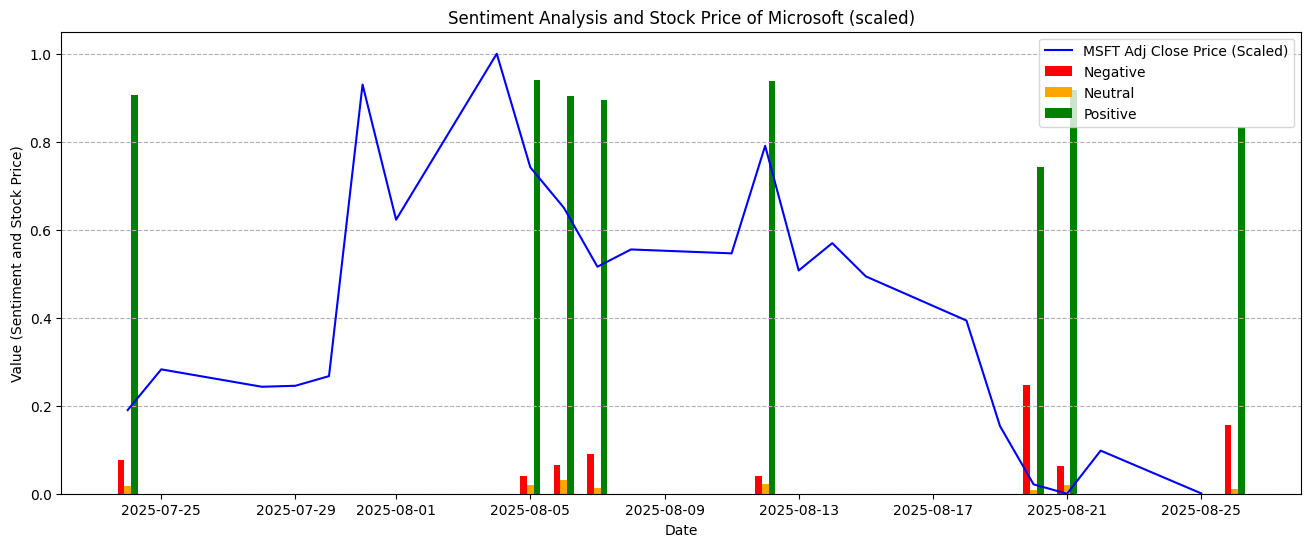

In [8]:
# Group by date and calculate average sentiment scores
df_grouped = df.groupby(df['date'].dt.date)[['negative', 'neutral', 'positive']].mean()

# Rename columns for clarity
df_grouped.columns = ['avg_negative', 'avg_neutral', 'avg_positive']

# Convert index back to datetime objects
df_grouped.index = pd.to_datetime(df_grouped.index)

# Fetch Microsoft stock data for the same date range
msft = yf.download("MSFT", start=df_grouped.index.min(), end=df_grouped.index.max())

# Scale the Microsoft price data
scaler = MinMaxScaler()
scaled_stock_price = scaler.fit_transform(msft[['Close']])

# Plot scaled price plot
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(msft.index, scaled_stock_price, color='blue', label='MSFT Adj Close Price (Scaled)')

# Plot the sentiment data
width = 0.2  # Adjust the width as needed
ax.bar(df_grouped.index - pd.DateOffset(days=width), df_grouped['avg_negative'], width=width, label='Negative', color='red')
ax.bar(df_grouped.index, df_grouped['avg_neutral'], width=width, label='Neutral', color='orange')
ax.bar(df_grouped.index + pd.DateOffset(days=width), df_grouped['avg_positive'], width=width, label='Positive', color='green')

# Set plot attributes (labels, ticks, title, legend, gridlines)
ax.set_xlabel('Date')
ax.set_title('Sentiment Analysis and Stock Price of Microsoft (scaled)')
ax.set_ylabel('Value (Sentiment and Stock Price)')
ax.legend()
ax.grid(True, axis='y', linestyle='--')
plt.show()

In [ ]:
# Group by date and calculate average sentiment scores
df_grouped = df.groupby(df['date'].dt.date)[['negative', 'neutral', 'positive']].mean()

# Rename columns for clarity
df_grouped.columns = ['avg_negative', 'avg_neutral', 'avg_positive']

# Convert index back to datetime objects
df_grouped.index = pd.to_datetime(df_grouped.index)

display(df_grouped.head())

In [ ]:
# Fetch news data from an RSS feed
def fetch_news_data(url):
    articles = []
    feed = feedparser.parse(url)
    for entry in feed.entries:
        articles.append({'title': entry.title, 'date': entry.published})
    return pd.DataFrame(articles)

# Example RSS feed for Microsoft news (replace with actual RSS feed URL)
rss_url = "https://www.microsoft.com/en-us/research/feed/"  # Replace with a relevant Microsoft news RSS feed
df = fetch_news_data(rss_url)

# Convert date column to datetime objects
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Load the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

# Function to get sentiment scores
def get_sentiment_scores(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    scores = outputs[0][0].detach().numpy()
    scores = softmax(scores)
    return scores

# Apply sentiment analysis to the news titles
sentiment_scores = np.array([get_sentiment_scores(title) for title in df['title']])
df['negative'] = sentiment_scores[:, 0]
df['neutral'] = sentiment_scores[:, 1]
df['positive'] = sentiment_scores[:, 2]

display(df.head())